# Spotify Streaming History

In [1]:
!pip install spotipy
!pip install lyricsgenius

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import ast
from typing import List
from os import listdir
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from spotipy import SpotifyOAuth, CacheFileHandler
import lyricsgenius as lg
import requests

In [2]:
url="https://raw.githubusercontent.com/danbm94/spotifyEDA/main/StreamingHistory0.json?token=AMNLDN74VPYBAX7YJEKEMYLATJ5A4"
music= pd.read_json(url)
url1="https://raw.githubusercontent.com/danbm94/spotifyEDA/main/StreamingHistory1.json?token=AMNLDNYDY2HIC26J2NXD6XDATJ5C6"
music1=pd.read_json(url1)

In [3]:
df=music.append(music1)

In [4]:
df['endTime']=pd.to_datetime(df['endTime'],infer_datetime_format=True, errors='coerce')
cats=['artistName','trackName']
df[cats] = df[cats].astype('category')

In [5]:
df= df[df['msPlayed']>1000]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15069 entries, 0 to 5746
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   endTime     15069 non-null  datetime64[ns]
 1   artistName  15069 non-null  category      
 2   trackName   15069 non-null  category      
 3   msPlayed    15069 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 663.7 KB


In [7]:
genius = lg.Genius('JSOKdC12oh_Ls6-G7VHnUyIpbHen9XNakCfiDPiOwS1CL9OevzOijj_COIcSBFbB', skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], remove_section_headers=True)

In [8]:
top50=df['artistName'].value_counts()

In [9]:
top50=top50[:50,]

In [10]:
def get_lyrics(ser, k):
    c = 0
    for name in ser:
        try:
            songs = (genius.search_artist(name, max_songs=k, sort='popularity')).songs
            s = [song.lyrics for song in songs]
            file.write("\n \n   <|endoftext|>   \n \n".join(s))
            c += 1
            print(f"Songs grabbed:{len(s)}")
        except:
            print(f"some exception at {name}: {c}")

In [15]:
df.loc[df['artistName']=="Radiohead"]

,endTime,artistName,trackName,msPlayed
138,2019-12-09 12:58:00,Radiohead,House Of Cards,328293
292,2019-12-11 07:58:00,Radiohead,Everything In Its Right Place,44483
320,2019-12-11 18:07:00,Radiohead,Karma Police - Remastered,261426
948,2019-12-25 12:44:00,Radiohead,House Of Cards,328293
955,2019-12-25 18:14:00,Radiohead,Everything In Its Right Place,248710
...,...,...,...,...
4992,2020-11-16 15:24:00,Radiohead,Go Slowly,228236
5170,2020-11-23 08:31:00,Radiohead,Palo Alto - Remastered,1126
5235,2020-11-24 16:51:00,Radiohead,The National Anthem,351693
5313,2020-11-27 10:46:00,Radiohead,Palo Alto - Remastered,231815


In [16]:
df['timesPlayed']=df['trackName'].map(df['trackName'].value_counts())

In [17]:
df['Year'] = pd.DatetimeIndex(df['endTime']).year
df['Month'] = pd.DatetimeIndex(df['endTime']).month

In [18]:
df.tail(25)

,endTime,artistName,trackName,msPlayed,timesPlayed,Year,Month
5721,2020-12-07 13:43:00,MGMT,Congratulations,235386,2,2020,12
5722,2020-12-07 13:46:00,Red Hot Chili Peppers,Higher Ground - Remastered,202053,15,2020,12
5723,2020-12-07 13:51:00,Blur,Ghost Ship,299133,49,2020,12
5724,2020-12-07 13:55:00,Daft Punk,Something About Us,232666,43,2020,12
5725,2020-12-07 13:59:00,Shuggie Otis,Strawberry Letter 23,239906,1,2020,12
5726,2020-12-07 14:05:00,Khruangbin,Time (You and I),342189,1,2020,12
5727,2020-12-07 14:09:00,Pond,Paint Me Silver,224973,4,2020,12
5728,2020-12-07 14:12:00,The Growlers,City Club,196728,4,2020,12
5729,2020-12-07 14:15:00,Wolfmother,Woman,175666,1,2020,12
5730,2020-12-07 14:18:00,Bloc Party,Banquet,201360,4,2020,12


## Spotiy authorization

In [19]:
client_id= "3bd02289c7fc487f9f57235e393dc2fe"
client_secret= '194bc5d8f14b405d8d92fc2bee38c0fb'
username= "1196124016"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [20]:
scope = "user-library-read user-read-recently-played user-top-read playlist-modify-public playlist-read-private playlist-read-collaborative"
redirect_uri= "http://127.0.0.1:8080"

In [21]:
spotify = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id=client_id,
        client_secret= client_secret,
        redirect_uri=redirect_uri,
        scope=scope,
        cache_handler=CacheFileHandler(username=username)
    )
)


In [16]:
def authenticate(redirect_uri, client_cred_manager, username, scope,client_id,client_secret):
    """
    Authenticates a user for a given spotify app.
    Parameters
    ----------
    redirect_uri : the redirect uri of the spotify app
    client_cred_manager : SpotifyClientCredentials containing client_id and client_secret
    username: spotify username
    scope: authorization scopes as a string
    client_id: spotify app client_id 
    client_secret: spotify app client_secret
    Returns
    -------
    sp: Spotify auth-token (SpotifyOAuth)
    """

    sp = spotipy.Spotify(client_credentials_manager = client_cred_manager)
    token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
    
    if token:
        sp = spotipy.Spotify(auth=token)
    else:
        print("Can't get token for", username)
    return sp

In [41]:
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

In [17]:
authenticate(redirect_uri, client_credentials_manager, username,scope, client_id, client_secret)

In [44]:
def get_id(track_name: str, token: str) -> str:
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json',
        'Authorization': f'Bearer ' + token,
    }
    params = [
        ('q', track_name),
        ('type','track')
    ]
    try: 
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        return track_id
    except:
        return None


In [21]:
ibet = get_id("I Bet That You Look Good on the Dancefloor", token, "Arctic Monkeys")
ibet

'0yMlW5eLp8T9E2u5BXuST2'

In [46]:
def get_features(track_id: str, token: str) -> dict:
    sp = spotipy.Spotify(auth=token)
    try:
        features = sp.audio_features([track_id])
        return features[0]
    except:
        return None

In [23]:
ibet_features= get_features(ibet, token)

In [24]:
ibet_features

{'danceability': 0.408,
 'energy': 0.628,
 'key': 0,
 'loudness': -5.992,
 'mode': 0,
 'speechiness': 0.0371,
 'acousticness': 0.283,
 'instrumentalness': 0,
 'liveness': 0.0457,
 'valence': 0.409,
 'tempo': 111.396,
 'type': 'audio_features',
 'id': '0yMlW5eLp8T9E2u5BXuST2',
 'uri': 'spotify:track:0yMlW5eLp8T9E2u5BXuST2',
 'track_href': 'https://api.spotify.com/v1/tracks/0yMlW5eLp8T9E2u5BXuST2',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0yMlW5eLp8T9E2u5BXuST2',
 'duration_ms': 308310,
 'time_signature': 4}

In [33]:
def get_streamings() -> List[dict]:
    
    files = [x for x in listdir()
             if x.split('.')[0][:-1] == 'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

In [47]:
streamings = get_streamings()
unique_tracks = list(set([streaming['trackName'] 
                for streaming in streamings]))

all_features = {}
for track in unique_tracks:
    track_id = get_id(track, token)
    features = get_features(track_id, token)
    if features:
        all_features[track] = features
        
with_features = []
for track_name, features in all_features.items():
    with_features.append({'name': track_name, **features})

In [53]:
music = pd.DataFrame(with_features)

In [67]:
music=music.rename(columns={"name":"trackName"})

In [68]:
df= pd.merge(df,music, on="trackName")

In [76]:
pink= df[df['artistName']=="Pink Floyd"]

In [77]:
pink

,endTime,artistName,trackName,msPlayed,timesPlayed,Year,Month,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
405,2019-12-09 08:48:00,Pink Floyd,Lost For Words - 2011 Remaster,1516,8,2019,12,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
406,2019-12-17 13:30:00,Pink Floyd,Lost For Words - 2011 Remaster,314960,8,2019,12,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
407,2019-12-19 11:31:00,Pink Floyd,Lost For Words - 2011 Remaster,2212,8,2019,12,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
408,2019-12-20 20:50:00,Pink Floyd,Lost For Words - 2011 Remaster,314961,8,2019,12,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
409,2019-12-24 11:12:00,Pink Floyd,Lost For Words - 2011 Remaster,314960,8,2019,12,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
410,2020-01-13 15:46:00,Pink Floyd,Lost For Words - 2011 Remaster,314960,8,2020,1,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
411,2020-01-14 09:03:00,Pink Floyd,Lost For Words - 2011 Remaster,314960,8,2020,1,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
412,2020-04-19 18:00:00,Pink Floyd,Lost For Words - 2011 Remaster,314960,8,2020,4,0.599,0.399,0,...,0.7120,0.2220,96.327,audio_features,7vQNnWSr6yXUJYrA3HoSl0,spotify:track:7vQNnWSr6yXUJYrA3HoSl0,https://api.spotify.com/v1/tracks/7vQNnWSr6yXU...,https://api.spotify.com/v1/audio-analysis/7vQN...,314961,4
1323,2019-12-10 16:38:00,Pink Floyd,Breathe (In The Air) - 2011 Remastered Version,169534,1,2019,12,0.431,0.375,11,...,0.1430,0.2580,128.153,audio_features,3zJRvtQkHQRTNEXSY8jQPR,spotify:track:3zJRvtQkHQRTNEXSY8jQPR,https://api.spotify.com/v1/tracks/3zJRvtQkHQRT...,https://api.spotify.com/v1/audio-analysis/3zJR...,169535,4
1336,2019-12-10 17:28:00,Pink Floyd,Us And Them - 2011 Remastered Version,469224,1,2019,12,0.356,0.302,2,...,0.6340,0.1260,72.623,audio_features,626wlz3bovvpH06PYht5R0,spotify:track:626wlz3bovvpH06PYht5R0,https://api.spotify.com/v1/tracks/626wlz3bovvp...,https://api.spotify.com/v1/audio-analysis/626w...,469224,4


In [79]:
import seaborn as sns

<AxesSubplot:xlabel='Month', ylabel='danceability'>

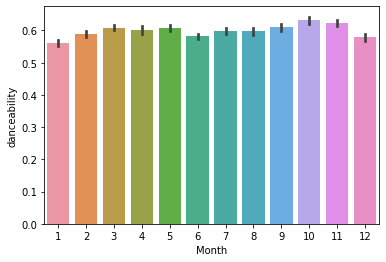

In [83]:
sns.barplot(x="Month",y="danceability",data=df)

In [85]:
df.describe(include="all", datetime_is_numeric=True)

,endTime,artistName,trackName,msPlayed,timesPlayed,Year,Month,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
count,14895,14895,14895,1.489500e+04,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000,14895.000000,...,14895.000000,14895.000000,14895.000000,14895,14895,14895,14895,14895,1.489500e+04,14895.000000
unique,NaN,2164,4943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,4856,4856,4856,4856,NaN,NaN
top,NaN,Arctic Monkeys,Yadnus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,audio_features,5zfg3qZOcjS4IFhazNk9PW,spotify:track:5zfg3qZOcjS4IFhazNk9PW,https://api.spotify.com/v1/tracks/5zfg3qZOcjS4...,https://api.spotify.com/v1/audio-analysis/5zfg...,NaN,NaN
freq,NaN,614,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14895,63,63,63,63,NaN,NaN
mean,2020-05-21 09:09:17.011077632,NaN,NaN,1.962217e+05,14.757905,2019.926821,6.033434,0.594661,0.633176,5.358577,...,0.188859,0.521439,119.614206,NaN,NaN,NaN,NaN,NaN,2.403491e+05,3.920913
min,2019-12-06 23:48:00,NaN,NaN,1.002000e+03,1.000000,2019.000000,1.000000,0.000000,0.000050,0.000000,...,0.019700,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.282700e+04,0.000000
25%,2020-02-18 15:40:30,NaN,NaN,1.381690e+05,2.000000,2020.000000,3.000000,0.477000,0.492000,2.000000,...,0.092600,0.328000,99.024000,NaN,NaN,NaN,NaN,NaN,1.933550e+05,4.000000
50%,2020-05-29 13:54:00,NaN,NaN,2.101730e+05,6.000000,2020.000000,6.000000,0.608000,0.673000,5.000000,...,0.121000,0.528000,116.903000,NaN,NaN,NaN,NaN,NaN,2.247540e+05,4.000000
75%,2020-08-06 09:03:00,NaN,NaN,2.590265e+05,28.000000,2020.000000,9.000000,0.725000,0.804000,9.000000,...,0.236000,0.715000,135.811000,NaN,NaN,NaN,NaN,NaN,2.693530e+05,4.000000
max,2020-12-07 20:16:00,NaN,NaN,2.937129e+06,63.000000,2020.000000,12.000000,0.979000,0.999000,11.000000,...,0.989000,0.993000,215.572000,NaN,NaN,NaN,NaN,NaN,1.421455e+06,5.000000


In [ ]:
#Analyze each month of 

In [72]:
df.to_csv("music.csv")